✅ Synthetic AQI dataset saved to 'synthetic_aqi_data.csv'


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:38:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:38:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Random Forest Accuracy: 0.8950
XGBoost Accuracy: 0.9300


<ipython-input-5-704676355be2>:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='viridis')


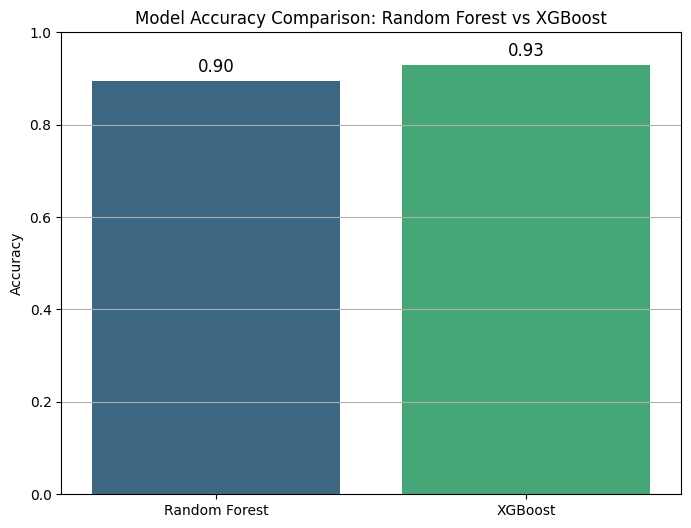

Accuracy: 0.9450
ROC AUC Score: 0.9906


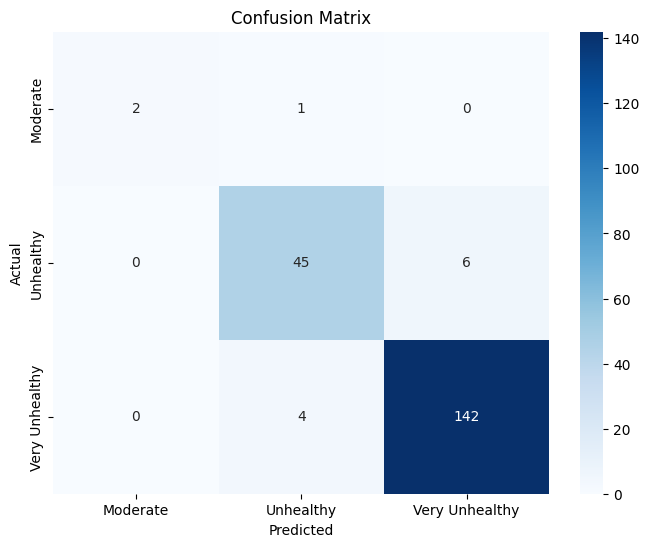

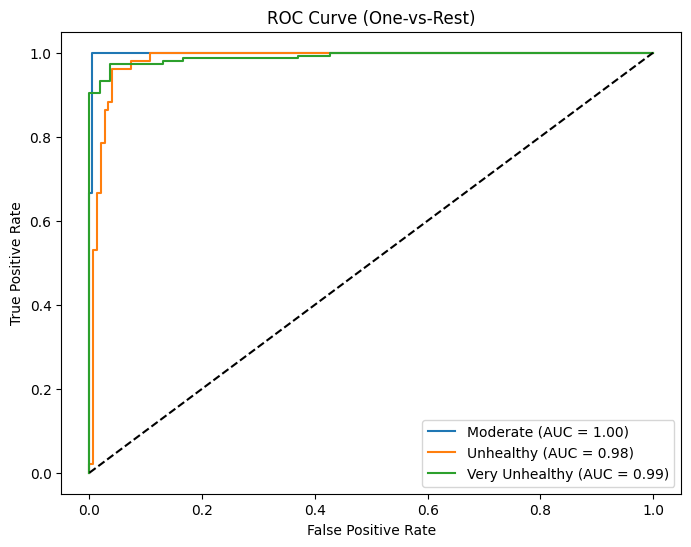

<ipython-input-5-704676355be2>:184: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=features_df, palette="coolwarm")


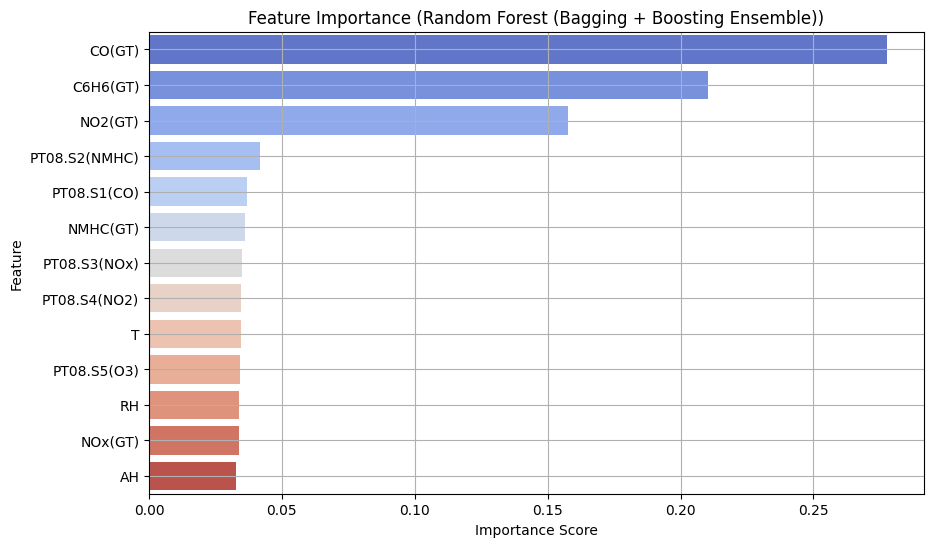

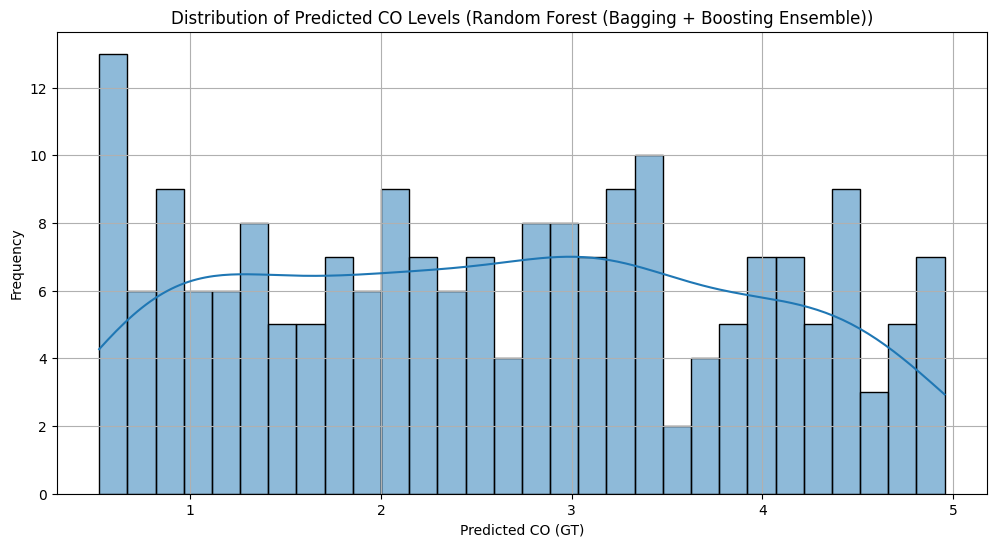

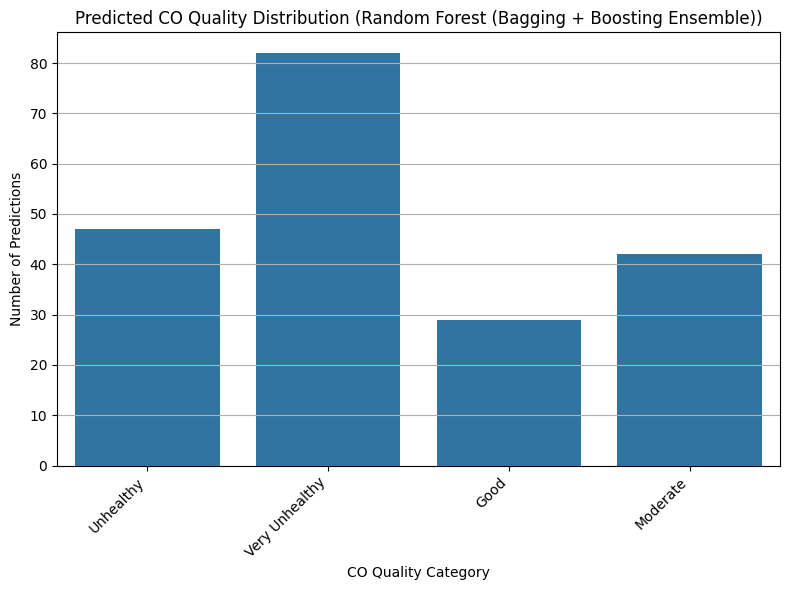

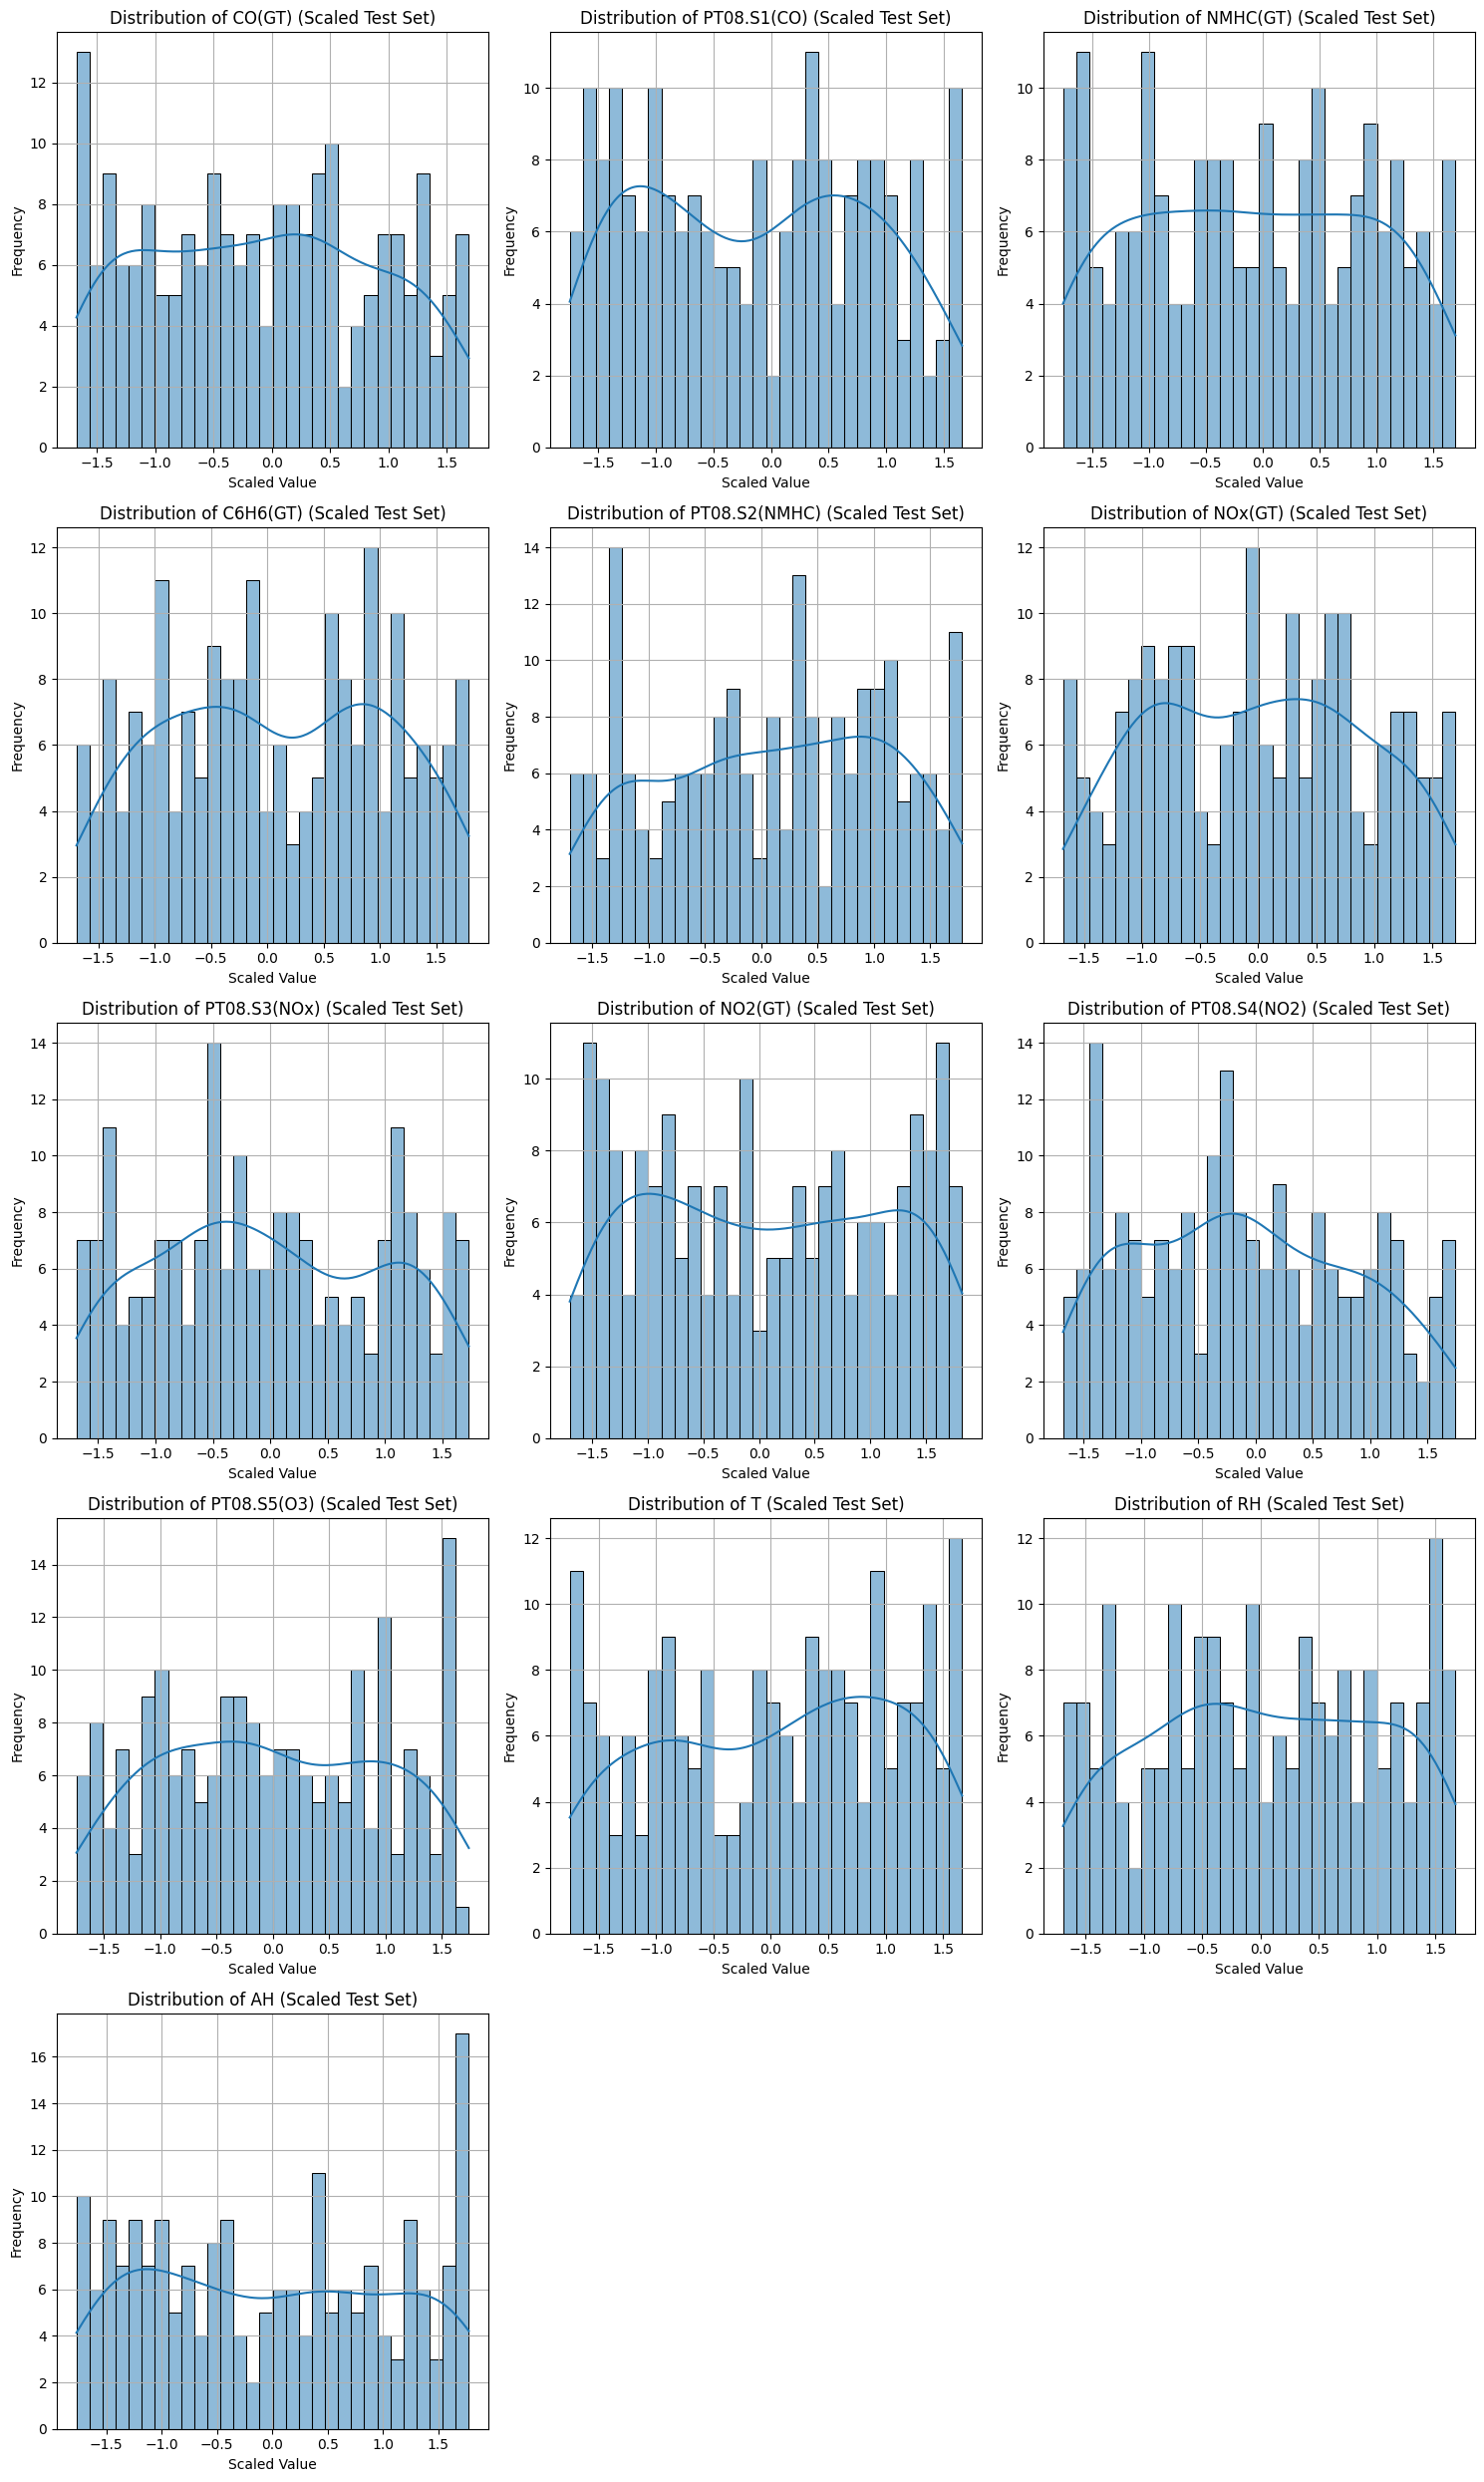

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Set random seed
np.random.seed(42)

# Generate synthetic AQI data
def generate_aqi_data(n_samples=1000):

    start_date = datetime(2004, 3, 10)
    data = {
        'Date': [(start_date + timedelta(hours=i)).strftime('%d/%m/%Y') for i in range(n_samples)],
        'Time': [(start_date + timedelta(hours=i)).strftime('%H.%M.%S') for i in range(n_samples)],
        'CO(GT)': np.random.uniform(0.5, 5.0, n_samples),
        'PT08.S1(CO)': np.random.uniform(800, 2000, n_samples),
        'NMHC(GT)': np.random.uniform(50, 300, n_samples),
        'C6H6(GT)': np.random.uniform(5, 20, n_samples),
        'PT08.S2(NMHC)': np.random.uniform(700, 1500, n_samples),
        'NOx(GT)': np.random.uniform(50, 500, n_samples),
        'PT08.S3(NOx)': np.random.uniform(700, 1500, n_samples),
        'NO2(GT)': np.random.uniform(50, 200, n_samples),
        'PT08.S4(NO2)': np.random.uniform(1000, 2000, n_samples),
        'PT08.S5(O3)': np.random.uniform(800, 1800, n_samples),
        'T': np.random.uniform(5, 35, n_samples),
        'RH': np.random.uniform(20, 80, n_samples),
        'AH': np.random.uniform(0.5, 1.5, n_samples)
    }
    df = pd.DataFrame(data)

    def calculate_aqi(row):
        score = (row['CO(GT)'] * 20 + row['NO2(GT)'] * 0.5 + row['C6H6(GT)'] * 5)
        if score <= 50:
            return 'Good'
        elif score <= 100:
            return 'Moderate'
        elif score <= 150:
            return 'Unhealthy'
        else:
            return 'Very Unhealthy'

    df['AQI'] = df.apply(calculate_aqi, axis=1)
    return df

# Generate synthetic dataset
df = generate_aqi_data(1000)
df.to_csv('synthetic_aqi_data.csv', index=False)
print("✅ Synthetic AQI dataset saved to 'synthetic_aqi_data.csv'")


# Preprocessing
X = df.drop(['Date', 'Time', 'AQI'], axis=1)
y = df['AQI']

# Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models
rf = RandomForestClassifier(random_state=42)
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Random Forest tuning
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train_scaled, y_train)
rf_best = rf_grid.best_estimator_

# XGBoost tuning
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1]
}
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=5, scoring='accuracy', n_jobs=-1)
xgb_grid.fit(X_train_scaled, y_train)
xgb_best = xgb_grid.best_estimator_

# Bagging Classifier
bagging = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42) # Changed 'base_estimator' to 'estimator'
bagging.fit(X_train_scaled, y_train)

# AdaBoost Classifier
adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)
adaboost.fit(X_train_scaled, y_train)

# Ensemble with Voting Classifier
ensemble = VotingClassifier(estimators=[
    ('rf', rf_best),
    ('xgb', xgb_best),
    ('bag', bagging),
    ('ada', adaboost)
], voting='soft')
ensemble.fit(X_train_scaled, y_train)

# Evaluate Random Forest separately
rf_preds = rf_best.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, rf_preds)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

# Evaluate XGBoost separately
xgb_preds = xgb_best.predict(X_test_scaled)
xgb_accuracy = accuracy_score(y_test, xgb_preds)
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")

# 📊 Compare Accuracies
models = ['Random Forest', 'XGBoost']
accuracies = [rf_accuracy, xgb_accuracy]

plt.figure(figsize=(8, 6))
sns.barplot(x=models, y=accuracies, palette='viridis')
plt.title('Model Accuracy Comparison: Random Forest vs XGBoost')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Because accuracy is between 0 and 1
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center', va='bottom', fontsize=12)
plt.grid(axis='y')
plt.show()


# Predictions
y_pred = ensemble.predict(X_test_scaled)
y_prob = ensemble.predict_proba(X_test_scaled)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
plt.figure(figsize=(8, 6))
for i in range(len(le.classes_)):
    fpr, tpr, _ = roc_curve(y_test == i, y_prob[:, i])
    plt.plot(fpr, tpr, label=f'{le.classes_[i]} (AUC = {roc_auc_score(y_test == i, y_prob[:, i]):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend()
plt.show()

# 📈 Feature Importance
best_model_name = "Random Forest (Bagging + Boosting Ensemble)"
model = rf_best
if model is not None:
    feature_importances = model.feature_importances_
    features_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10,6))
    sns.barplot(x='Importance', y='Feature', data=features_df, palette="coolwarm")
    plt.title(f"Feature Importance ({best_model_name})")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.grid()
    plt.show()

# 🔍 CO Quality Distribution
def get_co_quality(co_value):
    if co_value <= 1:
        return 'Good'
    elif co_value <= 2:
        return 'Moderate'
    elif co_value <= 3:
        return 'Unhealthy'
    else:
        return 'Very Unhealthy'

predictions = X_test['CO(GT)']
if predictions is not None:
    co_quality = [get_co_quality(pred) for pred in predictions]
    predictions_df = pd.DataFrame({'Predicted CO': predictions, 'CO Quality': co_quality})

    plt.figure(figsize=(12, 6))
    sns.histplot(predictions_df['Predicted CO'], bins=30, kde=True)
    plt.title(f'Distribution of Predicted CO Levels ({best_model_name})')
    plt.xlabel('Predicted CO (GT)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.countplot(x='CO Quality', data=predictions_df)
    plt.title(f'Predicted CO Quality Distribution ({best_model_name})')
    plt.xlabel('CO Quality Category')
    plt.ylabel('Number of Predictions')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(axis='y')
    plt.show()

# 📊 Concentrations of all features in Test Set
X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)

num_features = len(X.columns)
plt.figure(figsize=(15, 5 * np.ceil(num_features / 3)))
for i, column in enumerate(X.columns):
    plt.subplot(int(np.ceil(num_features / 3)), 3, i + 1)
    sns.histplot(X_test_df[column], bins=30, kde=True)
    plt.title(f'Distribution of {column} (Scaled Test Set)')
    plt.xlabel('Scaled Value')
    plt.ylabel('Frequency')
    plt.grid(True)
plt.tight_layout()
plt.show()
